In [5]:

import numpy as np 
import pandas as pd 
import os
print(os.listdir("../input"))

['skin-cancer-mnist-ham10000']


In [6]:
import pandas as pd 

df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
from os.path import isfile
from PIL import Image as pil_image
df['num_images'] = df.groupby('lesion_id')["image_id"].transform("count")

classes = df['dx'].unique()
labeldict = {}
for num, name in enumerate(classes):
    labeldict[name] = num
df['dx_id'] = df['dx'].map(lambda x: labeldict[x])


def expand_path(p):
    if isfile('../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/' + p + '.jpg'): return '../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/' + p + '.jpg'
    if isfile('../input/skin-cancer-mnist-ham10000/ham10000_images_part_2/' + p + '.jpg'): return '../input/skin-cancer-mnist-ham10000/ham10000_images_part_2/' + p + '.jpg'
    return p 
df['image_path'] = df['image_id']
df['image_path'] = df['image_path'].apply(expand_path)


df['images'] = df['image_path'].map(lambda x: np.asarray(pil_image.open(x).resize((150,112))))
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,num_images,dx_id,image_path,images
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,0,../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[188, 151, 193], [193, 156, 198], [192, 155,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,0,../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[24, 13, 22], [24, 13, 22], [24, 14, 25], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,0,../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[186, 126, 135], [189, 131, 142], [192, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,0,../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[23, 11, 16], [24, 11, 19], [26, 13, 22], [3..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,0,../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[129, 87, 109], [139, 94, 117], [148, 102, 1..."


In [8]:
from sklearn.model_selection import train_test_split

df_single = df[df['num_images'] == 1]
trainset1, testset = train_test_split(df_single, test_size=0.2,random_state = 80)
trainset2, validationset = train_test_split(trainset1, test_size=0.2,random_state = 600)
trainset3 = df[df['num_images'] != 1]
frames = [trainset2, trainset3]
trainset = pd.concat(frames)
def prepareimages(images):
    # images is a list of images
    images = np.asarray(images).astype(np.float64)
    images = images[:, :, :, ::-1]
    m0 = np.mean(images[:, :, :, 0])
    m1 = np.mean(images[:, :, :, 1])
    m2 = np.mean(images[:, :, :, 2])
    images[:, :, :, 0] -= m0
    images[:, :, :, 1] -= m1
    images[:, :, :, 2] -= m2
    return images
trainimages = prepareimages(list(trainset['images']))
testimages = prepareimages(list(testset['images']))
validationimages = prepareimages(list(validationset['images']))
trainlabels = np.asarray(trainset['dx_id'])
testlabels = np.asarray(testset['dx_id'])
validationlabels = np.asarray(validationset['dx_id'])

In [9]:
print("Train image shape: ",trainimages.shape)
print("Test image shape: ",testimages.shape)
print("Validation image shape: ", validationimages.shape)
print("Train label shape: ",trainlabels.shape)
print("validation label shape: ",validationlabels.shape)

Train image shape:  (8029, 112, 150, 3)
Test image shape:  (1103, 112, 150, 3)
Validation image shape:  (883, 112, 150, 3)
Train label shape:  (8029,)
validation label shape:  (883,)


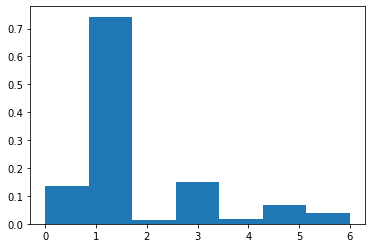

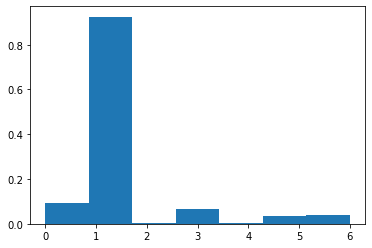

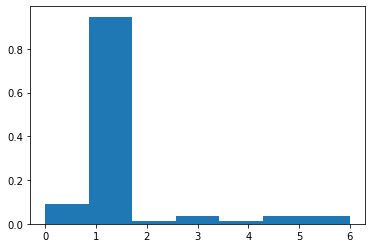

In [10]:
import matplotlib.pyplot as plt

plt.hist(trainlabels,bins = 7,density = True)
plt.show()

plt.hist(validationlabels,bins = 7,density= True)
plt.show()

plt.hist(testlabels,bins = 7,density= True)
plt.show()

In [11]:
from keras.preprocessing.image import ImageDataGenerator

trainimages = trainimages.reshape(trainimages.shape[0], *(112, 150, 3))

import tensorflow as tf

HEIGHT = 112
WIDTH = 150

def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
#     p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
#     p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
#     p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
#     p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
#     p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
#     p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    
#     if p_cutout > .5:
#         image = data_augment_cutout(image)
        
    
    return image
#This cutouts the images, and ML has to predict more on it(aggressive augmentation)
def data_augment_cutout(image, min_mask_size=(float(HEIGHT *.1), float(HEIGHT *.1)),
                       max_mask_size=(float(HEIGHT * .125), float(HEIGHT * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.float32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.float32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.float32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image
#This cutouts the above function randomly, just cuts off squares of the images
def random_cutout(image, height, width, channels=3, min_mask_size=(10, 10), max_mask_size=(80, 80), k=1):
    assert height > min_mask_size[0]
    assert width > min_mask_size[1]
    assert height > max_mask_size[0]
    assert width > max_mask_size[1]

    for i in range(k):
      mask_height = tf.random.uniform(shape=[], minval=min_mask_size[0], maxval=max_mask_size[0], dtype=tf.float32)
      mask_width = tf.random.uniform(shape=[], minval=min_mask_size[1], maxval=max_mask_size[1], dtype=tf.float32)

      pad_h = height - mask_height
      pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.float32)
      pad_bottom = pad_h - pad_top

      pad_w = width - mask_width
      pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.float32)
      pad_right = pad_w - pad_left

      cutout_area = tf.zeros(shape=[mask_height, mask_width, channels], dtype=tf.uint8)

      cutout_mask = tf.pad([cutout_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
      cutout_mask = tf.squeeze(cutout_mask, axis=0)
      image = tf.multiply(tf.cast(image, tf.float32), tf.cast(cutout_mask, tf.float32))

    return image

#This is experimental, this will freeze certain layers to make model train better  
def unfreeze_model(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, L.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
            
def unfreeze_block(model, block_name=None, n_top=3):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers[:-n_top]:
        if isinstance(layer, L.BatchNormalization):
            layer.trainable = False
        else:
            if block_name and (block_name in layer.name):
                layer.trainable = True
    
#Here is where I create the 3 functions (get_label) to (make_dataset_unbactched) to turn the image filenames into tensorflow BatchedDataset

def parse_image(image, augment = False):
    image = tf.cast(image, dtype=tf.float32)
    if augment:
        image = data_augment(image)
    image = tf.image.resize(image, [112, 150])/255.0 # size the image and normalize
    
    return image

trainimages = parse_image(trainimages, augment=True)

AttributeError: 'numpy.float32' object has no attribute '__index__'

In [ ]:
print("Train image shape: ",trainimages.shape)
print("Test image shape: ",testimages.shape)
print("Validation image shape: ", validationimages.shape)
print("Train label shape: ",trainlabels.shape)
print("validation label shape: ",validationlabels.shape)

In [ ]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.applications import ResNet50
from keras import regularizers
import numpy as np

model = Sequential()
num_labels = 7

base_model = ResNet50(include_top=False,input_shape=(224,224,3),pooling = 'avg', weights="imagenet")
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02)))

for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-22:]:
    layer.trainable = True

model.summary()

In [ ]:
print("Train image shape: ",trainimages.shape)
print("Test image shape: ",testimages.shape)
print("Validation image shape: ", validationimages.shape)
print("Train label shape: ",trainlabels.shape)
print("validation label shape: ",validationlabels.shape)

In [ ]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam (lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
print("Train image shape: ",trainimages.shape)
print("Test image shape: ",testimages.shape)
print("Validation image shape: ", validationimages.shape)
print("Train label shape: ",trainlabels.shape)
print("validation label shape: ",validationlabels.shape)

In [ ]:
# Fit the model
import keras
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
# class CustomModelCheckPoint(keras.callbacks.Callback):
#     def __init__(self,**kargs):
#         super(CustomModelCheckPoint,self).__init__(**kargs)
#         self.epoch_accuracy = {} # loss at given epoch
#         self.epoch_loss = {} # accuracy at given epoch
#     def on_epoch_begin(self,epoch, logs={}):
#             # Things done on beginning of epoch. 
#             return

#     def on_epoch_end(self, epoch, logs={}):
#             # things done on end of the epoch
#             self.epoch_accuracy[epoch] = logs.get("acc")
#             self.epoch_loss[epoch] = logs.get("loss")
#             self.model.save_weights("../output/resnet50/name-of-model-%d.h5" %epoch)
            
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 4)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.h5', monitor = 'val_loss', save_best_only = True,save_weights_only = False, mode = 'auto')
            
epochs = 30 
batch_size = 20
trainhistory = model.fit(trainimages,trainlabels, 
                        batch_size=batch_size,
                        epochs = epochs, 
                        validation_data = (validationimages,validationlabels),
                        verbose = 1, steps_per_epoch=trainimages.shape[0] // batch_size,
                        callbacks=[cb_checkpointer, cb_early_stopper])

In [ ]:
print("Train image shape: ",trainimages.shape)
print("Test image shape: ",testimages.shape)
print("Validation image shape: ", validationimages.shape)
print("Train label shape: ",trainlabels.shape)
print("validation label shape: ",validationlabels.shape)

In [ ]:
import matplotlib.pyplot as plt
acc = trainhistory.history['accuracy']
val_acc = trainhistory.history['val_accuracy']
loss = trainhistory.history['loss']
val_loss = trainhistory.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, '', label='Training loss')
plt.plot(epochs, val_loss, '', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc,'', label='Training accuracy')
plt.plot(epochs, val_acc, '', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


In [ ]:
model.load_weights("../working/best.h5")
test_loss, test_acc = model.evaluate(testimages, testlabels, verbose=1)
print("test_accuracy = %f  ;  test_loss = %f" % (test_acc, test_loss))

In [ ]:
from sklearn.metrics import confusion_matrix
train_pred = model.predict(trainimages)
train_pred_classes = np.argmax(train_pred,axis = 1)
test_pred = model.predict(testimages)
# Convert predictions classes to one hot vectors 
test_pred_classes = np.argmax(test_pred,axis = 1) 

confusionmatrix = confusion_matrix(testlabels, test_pred_classes)
confusionmatrix

In [ ]:
from sklearn.metrics import classification_report
labels = labeldict.keys()
# Generate a classification report
trainreport = classification_report(trainlabels, train_pred_classes, target_names=list(labels))
testreport = classification_report(testlabels, test_pred_classes, target_names=list(labels))

print(trainreport)
print(testreport)